In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy import stats
from math import radians, cos, sin, asin, sqrt, atan2
try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
except:
    import nltk
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re

In [2]:
sid = SentimentIntensityAnalyzer()

In [3]:
dirty = pd.read_csv("29893909_dirty_data.csv")
missing = pd.read_csv("29893909_missing_data.csv")
outlier = pd.read_csv("29893909_outlier_data.csv")
warehouses = pd.read_csv("warehouses.csv")

In [4]:
warehouse_names = ["Nickolson", "Thompson", "Bakers"]

In [5]:
wh_locations = [np.array(((warehouses["lat"][i], warehouses["lon"][i]))) for i in warehouses.index]

In [6]:
def distance(p1, p2):
    lat1, lon1 = p1
    lat2, lon2 = p2
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6378

    distance = R * c
    return distance

In [8]:
# It is observed that there are certain points where the latitudes and longitudes have been interchanged
print(dirty.customer_long.max(), dirty.customer_long.min())
print(dirty.customer_lat.max(), dirty.customer_lat.min())

145.01771630000005 -37.824382299999996
145.010299 -37.832478


In [31]:
for index in dirty.index:
    lat = dirty.loc[index, "customer_lat"]
    lon = dirty.loc[index, "customer_long"]
    
    # Handling cases with interchanged latitudes and longitudes
    if (lat > 100) or (lon < 30):
        dirty.loc[index, "customer_lat"] = lon
        dirty.loc[index, "customer_long"] = lat 
        
    # Nearest warehouse
    coordinate = np.array((lat, lon))
    distances = [distance(i, coordinate) for i in wh_locations]
    min_dist = round(min(distances), 4)
    if min_dist !=  dirty.loc[index, 'distance_to_nearest_warehouse']:
        dirty.loc[index, 'distance_to_nearest_warehouse'] = min_dist
    
    dirty.loc[index, 'nearest_warehouse'] = warehouse_names[distances.index(min(distances))]

In [32]:
for index in dirty.index[:10]:
    try:
        polarity = sid.polarity_scores(dirty.loc[index, 'latest_customer_review'])['compound']
        if polarity > 0:
            happy = True
        else:
            happy = False
        if happy != bool(dirty.loc[index, 'is_happy_customer']):
            print(happy, dirty.loc[index, 'latest_customer_review'])
    except:
        pass

True five stars i love this phone...
False None


In [65]:
seasons = {
    1: "Summer",
    2: "Summer",
    3: "Autumn",
    4: "Autumn",
    5: "Autumn",
    6: "Winter",
    7: "Winter",
    8: "Winter",
    9: "Spring",
    10: "Spring",
    11: "Spring",
    12: "Summer",
}

for index in dirty.index:
    try:
        polarity = sid.polarity_scores(dirty.loc[index, 'latest_customer_review'])['compound']
        if polarity > 0:
            dirty.loc[index, 'is_happy_customer'] = True
        else:
            dirty.loc[index, 'is_happy_customer'] = False
            
        # Handling cases with interchanged latitudes and longitudes
        if (dirty.loc[index, 'customer_lat'] > 100) or (dirty.loc[index, 'customer_long'] < 30):
            lat = dirty.loc[index, "customer_lat"]
            lon = dirty.loc[index, "customer_long"]
            dirty.loc[index, "customer_lat"] = lon
            dirty.loc[index, "customer_long"] = lat

        # Ensuring that season and nearest_warehouse have consistent capitalization
        date = dirty.loc[index, 'date']
        try:
            season = seasons[pd.to_datetime(date, format="%Y-%m-%d").month]
        except:
            if re.match("[0-3][0-9]-[0-1][0-9]-[0-9][0-9][0-9][0-9]", date):
                season = seasons[pd.to_datetime(date, format="%d-%m-%Y").month]
            else:
                season = seasons[pd.to_datetime(date, format="%Y-%d-%m").month]
        dirty.loc[index, 'season'] = season
        
        dirty.loc[index, 'nearest_warehouse'] = dirty.loc[index, 'nearest_warehouse'].capitalize()

        # Ensuring that order_total = order_price + delivery_charges - coupon_discount
        dc = dirty.loc[index, 'delivery_charges']
        op = dirty.loc[index, 'order_price']
        cd = dirty.loc[index, 'coupon_discount']
        ot = dirty.loc[index, 'order_total']
        if not (ot == (dc + op - cd)):
            dirty.loc[index, 'order_total'] = dc + op - cd
    except Exception as e:
        print(index, e)
        dirty.loc[index]
        
        pass

# Outlier Analysis

All the points that lie beyond 3 standard deviations away from the mean are consdiered to be outliers.

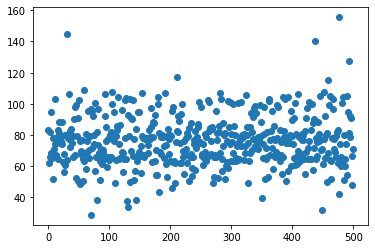

In [12]:
plt.scatter([_ for _ in range(500)], outlier.delivery_charges)

In [13]:
def outlier_numeric(df, Data):
    return df[np.abs(df[Data]-df[Data].mean()) > (3*df[Data].std())]

In [14]:
outliers_delivery_charges = outlier_numeric(outlier, 'delivery_charges')

In [15]:
outliers_delivery_charges

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
31,ORD046343,ID0579391888,2019-12-06,Nickolson,"[('iAssist Line', 2), ('Toshika 750', 1)]",8770,144.915,-37.821683,144.956248,25,6722.415,Summer,True,1.2192,i have never been more satisfied with a produc...,True
437,ORD167361,ID0122741155,2019-01-09,Nickolson,"[('Olivia x460', 1), ('Alcon 10', 1)]",10175,140.250,-37.822161,144.960781,25,7771.500,Summer,True,0.8673,great phone is great phone and i love it.,True
476,ORD102449,ID1463620745,2019-11-30,Bakers,"[('Universe Note', 1), ('pearTV', 2), ('Candle...",16500,155.490,-37.816779,145.005593,0,16655.490,Spring,True,1.1833,"easy to use phone is very easy to learn, espec...",True
493,ORD270575,ID0250933633,2019-04-04,Bakers,"[('Toshika 750', 1), ('Lucent 330S', 2), ('pea...",13090,127.560,-37.825964,145.004760,15,11254.060,Autumn,True,1.9651,"great, especially for price!! only had it for ...",True


# Missing Values
Columns with no missing values
   * is_expedited_delivery
   * customer_lat
   * customer_long

In [16]:
def impute_mean(df, column):
    dataset = df[[column]]
    dataset.fillna(dataset.mean(), inplace=True)
    df[column] = dataset[column]
    
    return df

In [17]:
missing = impute_mean(missing, "order_price")
missing = impute_mean(missing, "delivery_charges")

/home/sai/.local/lib/python3.8/site-packages/pandas/core/series.py:4529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [18]:
for index in missing.index:
    # Compute is_happy_customer if missing
    if missing.loc[index, 'is_happy_customer'] not in [1.0, 0.0]:
        missing.loc[index, 'is_happy_customer'] = (sid.polarity_scores(missing.loc[index, 'latest_customer_review'])['compound'])
        
    # Compute order_total if missing
    dc = missing.loc[index, 'delivery_charges']
    op = missing.loc[index, 'order_price']
    cd = missing.loc[index, 'coupon_discount']
    ot = missing.loc[index, 'order_total']
    if not (ot == (dc + op - cd)):
        missing.loc[index, 'order_total'] = dc + op - cd
    ""

In [19]:
for index in missing.index:
    lat = missing.loc[index, "customer_lat"]
    lon = missing.loc[index, "customer_long"]
        
    # Nearest warehouse
    coordinate = np.array((lat, lon))
    distances = [distance(i, coordinate) for i in wh_locations]
    min_dist = round(min(distances), 4)
    missing.loc[index, 'distance_to_nearest_warehouse'] = min_dist
    
    missing.loc[index, 'nearest_warehouse'] = warehouse_names[distances.index(min(distances))]